In [6]:
import pandas as pd
import torch
from torch import nn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import seaborn as sns

In [7]:
df_origin = pd.read_csv("finalizedDataset.csv",index_col=0)
df = pd.read_csv("finalizedDataset.csv",index_col=0)
df.set_index('Date', inplace=True)
train_X = pd.DataFrame()
test_X = pd.DataFrame()
train_y = pd.DataFrame()
test_y = pd.DataFrame()
for ticker in  df['Ticker'].unique():
    rows = df[df['Ticker'] == ticker]
    y = rows['Price_Stock']
    train_sub_X, test_sub_X, train_sub_y, test_sub_y = train_test_split(rows, y, test_size=0.2, shuffle=False)
    train_X = pd.concat([train_X, train_sub_X ])
    train_y = pd.concat([train_y, train_sub_y])
    test_X = pd.concat([test_X, test_sub_X])
    test_y = pd.concat([test_y, test_sub_y])

train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_X)
train_y = pd.get_dummies(train_y)
test_y = pd.get_dummies(test_y)

train_scaler = MinMaxScaler()
train_X = train_scaler.fit_transform(train_X)
test_X = train_scaler.transform(test_X)

test_scaler = MinMaxScaler()
train_y = test_scaler.fit_transform(train_y)
test_y = test_scaler.transform(test_y)

train_X = torch.tensor(train_X, dtype=torch.float32) 
test_X = torch.tensor(test_X, dtype=torch.float32) 
train_y = torch.tensor(train_y, dtype=torch.float32) 
test_y = torch.tensor(test_y, dtype=torch.float32) 

In [8]:
sequence = 5
X = []
y = []

for i in range(6):
    start = i*200
    end = (i+1)*200
    for j in range(start+sequence, end):
        X.append(train_X[j-sequence:j,:]) #[0:5] [1:6] ... [2:7] ...
        y.append(train_y[j :j + 1])       #[5:6] [6:7] ... [7:8] ...
X = torch.stack(X, dim=0)
y = torch.stack(y, dim=0)
# 195 sequence per ticker
print(X.shape, y.shape)

torch.Size([1170, 5, 11]) torch.Size([1170, 1, 1])


In [9]:
dataset = TensorDataset(X, y)
batch_size = 5
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [10]:
X_test = []
y_test = []

for i in range(6):
    start = i*50
    end = (i+1)*50
    for j in range(start+sequence, end):
        X_test.append(test_X[j-sequence:j,:]) #[0:5] [1:6] ... [2:7] ...
        y_test.append(test_y[j :j + 1])       #[5:6] [6:7] ... [7:8] ...
X_test = torch.stack(X_test, dim=0)
y_test = torch.stack(y_test, dim=0)
# 45 sequence per ticker
print(X_test.shape, y_test.shape)

# 54 total, 9 each ticker, 9x5 = 45 days
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([270, 5, 11]) torch.Size([270, 1, 1])


In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plotResults(dates, y, y_pred, title):
    ax = sns.lineplot(x=dates, y=y,label='Actual')
    sns.lineplot(x=dates, y=y_pred, label='Predicted')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.tick_params(axis='x', rotation=45)
    plt.title(title)

def compare(actual, preds):
    same_count = 0
    for i in range(1, len(actual)):
        actual_diff = actual[i] - actual[i - 1]
        preds_diff = preds[i] - preds[i - 1]

        if (actual_diff >= 0 and preds_diff >= 0) or (actual_diff < 0 and preds_diff < 0):
            same_count += 1
    return same_count

In [84]:
class Model(nn.Module):
   def __init__(self, input_size, hidden_size):
      super().__init__()
      self.lstm =  nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=1,batch_first=True)
      self.linear = nn.Linear(hidden_size,1)
      
   def forward(self, X):
      out, _ = self.lstm(X)
      out = out[:, -1, :]
      out = self.linear(out)
      return out        

In [91]:
model = Model(11,64)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model.train()
for epoch in range(50):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'epoch: {epoch + 1} loss: {running_loss:.3f}')

epoch: 1 loss: 9.704
epoch: 2 loss: 7.254
epoch: 3 loss: 5.647
epoch: 4 loss: 4.337
epoch: 5 loss: 3.343
epoch: 6 loss: 2.652
epoch: 7 loss: 2.201
epoch: 8 loss: 1.909
epoch: 9 loss: 1.706
epoch: 10 loss: 1.553
epoch: 11 loss: 1.426
epoch: 12 loss: 1.316
epoch: 13 loss: 1.219
epoch: 14 loss: 1.133
epoch: 15 loss: 1.057
epoch: 16 loss: 0.992
epoch: 17 loss: 0.935
epoch: 18 loss: 0.888
epoch: 19 loss: 0.849
epoch: 20 loss: 0.816
epoch: 21 loss: 0.791
epoch: 22 loss: 0.770
epoch: 23 loss: 0.754
epoch: 24 loss: 0.741
epoch: 25 loss: 0.731
epoch: 26 loss: 0.722
epoch: 27 loss: 0.715
epoch: 28 loss: 0.708
epoch: 29 loss: 0.702
epoch: 30 loss: 0.695
epoch: 31 loss: 0.689
epoch: 32 loss: 0.682
epoch: 33 loss: 0.675
epoch: 34 loss: 0.667
epoch: 35 loss: 0.660
epoch: 36 loss: 0.652
epoch: 37 loss: 0.644
epoch: 38 loss: 0.635
epoch: 39 loss: 0.627
epoch: 40 loss: 0.618
epoch: 41 loss: 0.609
epoch: 42 loss: 0.600
epoch: 43 loss: 0.591
epoch: 44 loss: 0.582
epoch: 45 loss: 0.574
epoch: 46 loss: 0.5

Percent of same trends for  AAPL :  0.5333333333333333
MSELoss:  11.138087385395481
Percent of same trends for  GOOG :  0.5333333333333333
MSELoss:  32.468676242267854
Percent of same trends for  TSLA :  0.4666666666666667
MSELoss:  606.4143636668954
Percent of same trends for  KO :  0.35555555555555557
MSELoss:  10.306227991429319
Percent of same trends for  OXY :  0.4666666666666667
MSELoss:  24.47091926564454
Percent of same trends for  BAC :  0.4666666666666667
MSELoss:  2.509058371824187


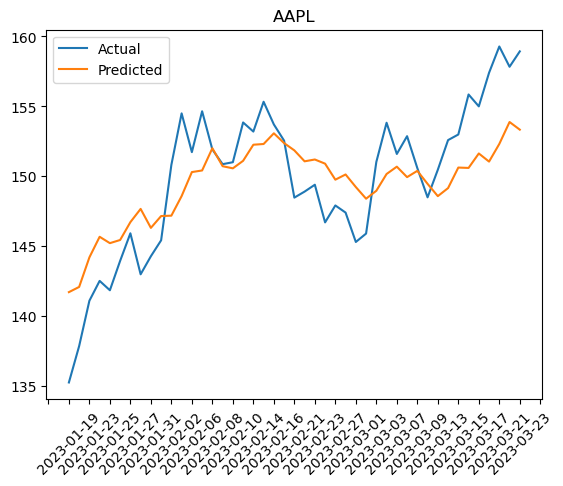

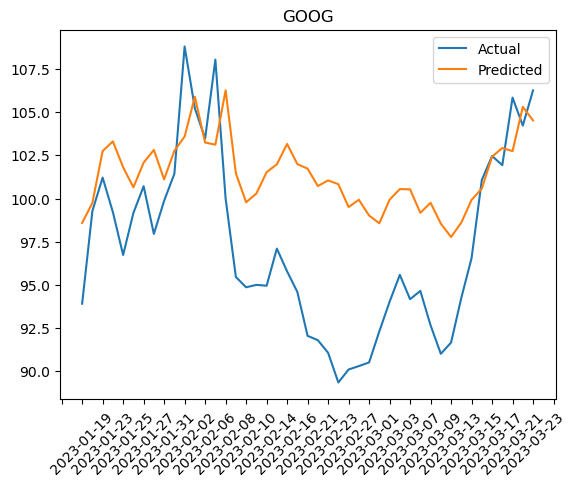

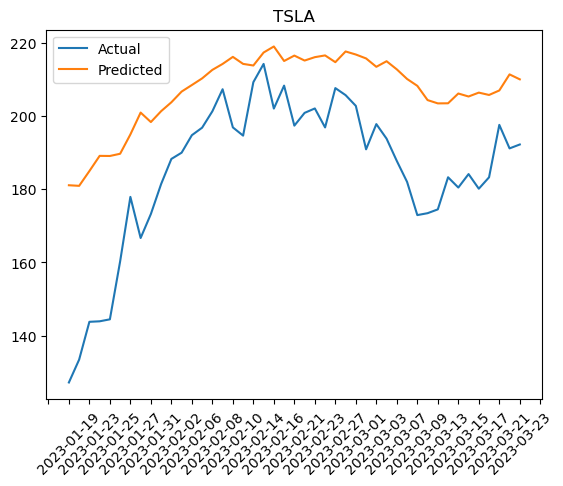

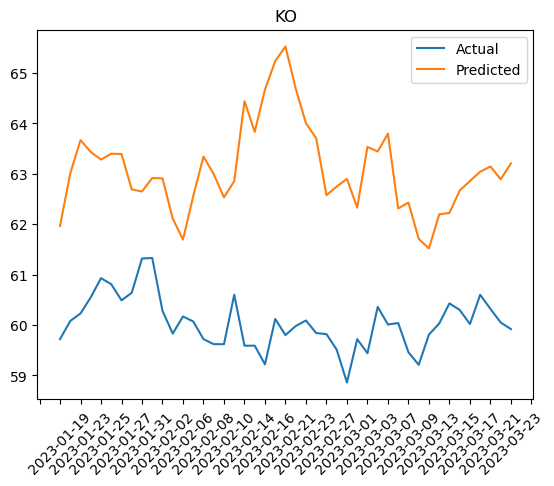

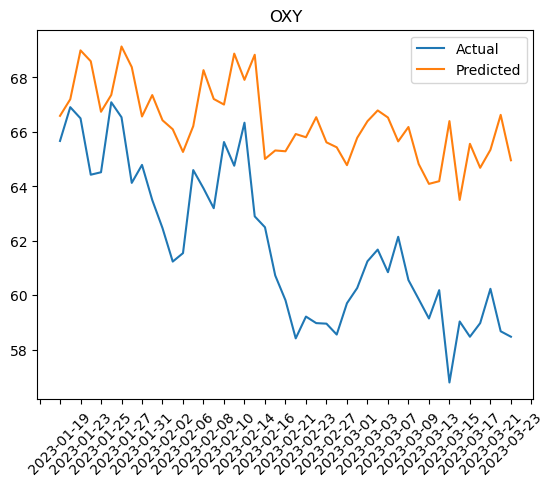

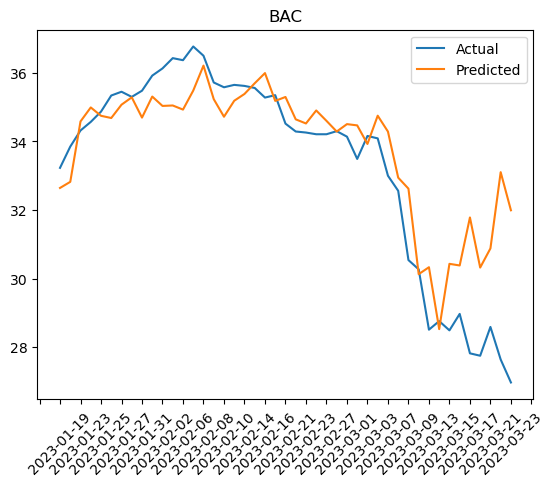

In [105]:
model.eval()
actual = []
preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        pred = model(x)
        actual.append(y.squeeze(-1))
        preds.append(pred)
preds = torch.cat(preds, dim=0)
actual = torch.cat(actual,dim=0)

dates = df_origin[200:250]['Date'].values
dates = dates[5:]
ticker = df_origin['Ticker'].unique()
preds_unscaled1 = test_scaler.inverse_transform(preds)
actual_unscaled1 = test_scaler.inverse_transform(actual)

for i in range(6):
    result = compare(actual_unscaled1[i*45:(i+1)*45], preds_unscaled1[i*45:(i+1)*45])
    print("Percent of same trends for ", ticker[i], ": ", result/45)
    print("MSELoss: ", np.mean((actual_unscaled1[i*45:(i+1)*45] - preds_unscaled1[i*45:(i+1)*45]) ** 2))

for i,t in enumerate(ticker):
    length = 45
    plt.figure()
    plotResults(dates=dates, y=actual_unscaled1[i*length:(i+1)*length].reshape(-1),y_pred=preds_unscaled1[i*length:(i+1)*length].reshape(-1),title=t)
    plt.show()


In [94]:
class Model2(nn.Module):
   def __init__(self, input_size, hidden_size):
      super().__init__()
      self.lstm =  nn.LSTM(input_size=input_size,hidden_size=hidden_size,num_layers=2,batch_first=True, bidirectional=True)
      self.linear = nn.Linear(hidden_size*2,1)
      
   def forward(self, X):
      out, _ = self.lstm(X)
      out = out[:, -1, :]
      out = self.linear(out)
      return out  

In [95]:
model2 = Model2(11,64)
criterion = nn.MSELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
model2.train()
for epoch in range(50):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model2(x)
        loss = criterion(outputs, y.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'epoch: {epoch + 1} loss: {running_loss:.3f}')

epoch: 1 loss: 10.499
epoch: 2 loss: 10.219
epoch: 3 loss: 9.969
epoch: 4 loss: 9.716
epoch: 5 loss: 9.449
epoch: 6 loss: 9.158
epoch: 7 loss: 8.831
epoch: 8 loss: 8.458
epoch: 9 loss: 8.029
epoch: 10 loss: 7.534
epoch: 11 loss: 6.968
epoch: 12 loss: 6.327
epoch: 13 loss: 5.622
epoch: 14 loss: 4.873
epoch: 15 loss: 4.119
epoch: 16 loss: 3.410
epoch: 17 loss: 2.797
epoch: 18 loss: 2.314
epoch: 19 loss: 1.967
epoch: 20 loss: 1.735
epoch: 21 loss: 1.586
epoch: 22 loss: 1.488
epoch: 23 loss: 1.417
epoch: 24 loss: 1.360
epoch: 25 loss: 1.311
epoch: 26 loss: 1.266
epoch: 27 loss: 1.223
epoch: 28 loss: 1.183
epoch: 29 loss: 1.145
epoch: 30 loss: 1.109
epoch: 31 loss: 1.074
epoch: 32 loss: 1.042
epoch: 33 loss: 1.011
epoch: 34 loss: 0.982
epoch: 35 loss: 0.955
epoch: 36 loss: 0.930
epoch: 37 loss: 0.907
epoch: 38 loss: 0.885
epoch: 39 loss: 0.865
epoch: 40 loss: 0.847
epoch: 41 loss: 0.830
epoch: 42 loss: 0.815
epoch: 43 loss: 0.800
epoch: 44 loss: 0.788
epoch: 45 loss: 0.776
epoch: 46 loss: 0

Percent of same trends for  AAPL :  0.37777777777777777
MSELoss:  16.80295273764209
Percent of same trends for  GOOG :  0.5555555555555556
MSELoss:  201.72132949466803
Percent of same trends for  TSLA :  0.4444444444444444
MSELoss:  1450.7904404848646
Percent of same trends for  KO :  0.5333333333333333
MSELoss:  129.37704649547018
Percent of same trends for  OXY :  0.37777777777777777
MSELoss:  63.42096272959061
Percent of same trends for  BAC :  0.5777777777777777
MSELoss:  2.9606894807663107


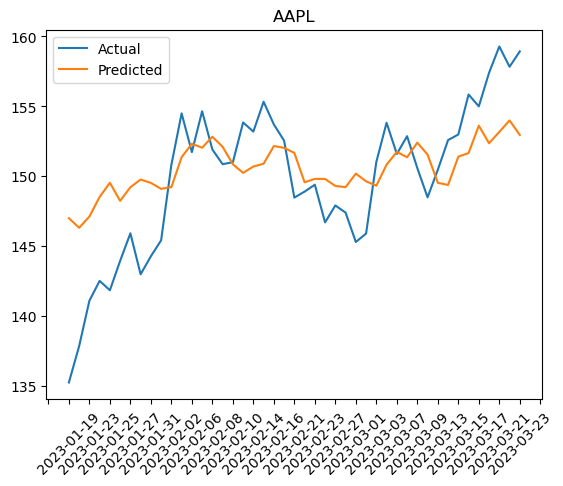

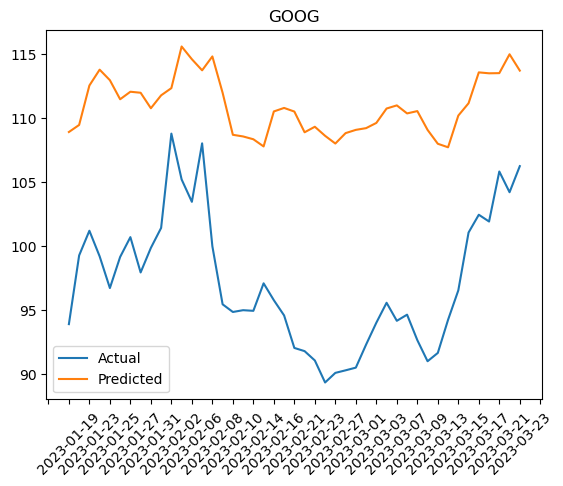

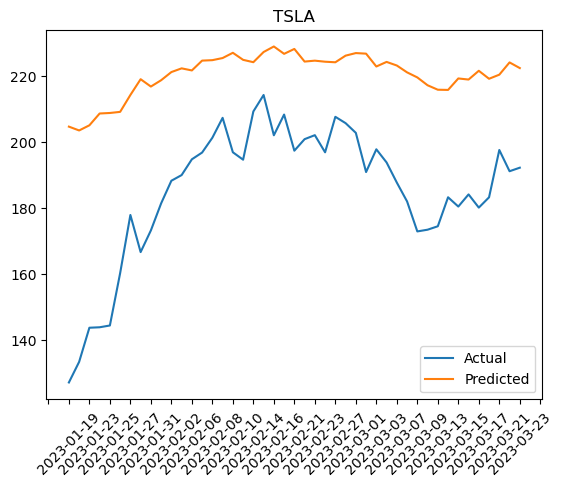

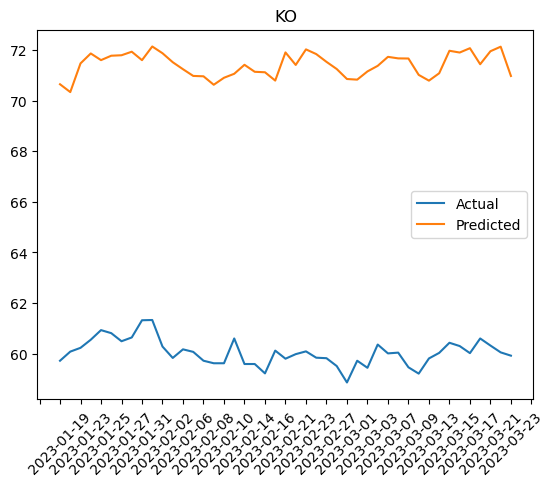

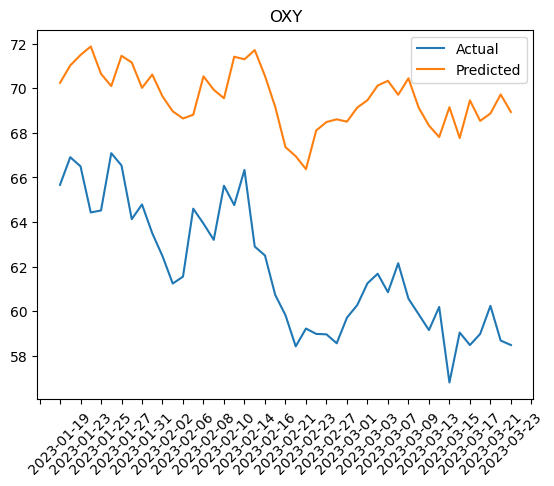

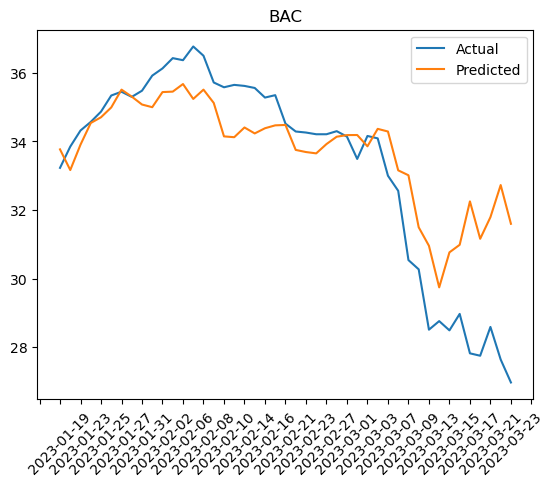

In [98]:
model2.eval()
actual = []
preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        pred = model2(x)
        actual.append(y.squeeze(-1))
        preds.append(pred)
preds = torch.cat(preds, dim=0)
actual = torch.cat(actual,dim=0)
    
dates = df_origin[200:250]['Date'].values
dates = dates[5:]
ticker = df_origin['Ticker'].unique()
preds_unscaled2 = test_scaler.inverse_transform(preds)
actual_unscaled2 = test_scaler.inverse_transform(actual)

for i in range(6):
    result = compare(actual_unscaled2[i*45:(i+1)*45], preds_unscaled2[i*45:(i+1)*45])
    print("Percent of same trends for ", ticker[i], ": ", result/45)
    print("MSELoss: ", np.mean((actual_unscaled2[i*45:(i+1)*45] - preds_unscaled2[i*45:(i+1)*45]) ** 2))

for i,t in enumerate(ticker):
    length = 45
    plt.figure()
    plotResults(dates=dates, y=actual_unscaled2[i*length:(i+1)*length].reshape(-1),y_pred=preds_unscaled2[i*length:(i+1)*length].reshape(-1),title=t)
    plt.show()


In [45]:
class Model3(nn.Module):
   def __init__(self, hidden_size):
      super().__init__()
      self.cnn = nn.Sequential(
         nn.Conv1d(11, 128, kernel_size=2),
         nn.ReLU(),
         nn.Dropout(0.2)
      )
      self.lstm =  nn.LSTM(input_size=128,hidden_size=hidden_size,num_layers=1,batch_first=True, bidirectional=True)
      self.linear = nn.Linear(hidden_size*2,1)
      
   def forward(self, X):
      X = X.permute(0, 2, 1)
      out = self.cnn(X)
      out = out.permute(0, 2, 1)
      out, _ = self.lstm(out)
      out = out[:, -1, :]
      out = self.linear(out)
      return out  

model3 = Model3(128)
criterion = nn.MSELoss()
optimizer = optim.SGD(model3.parameters(), lr=0.1e-3, momentum=0.9)

model3.train()
for epoch in range(70):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model3(x)
        loss = criterion(outputs, y.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'epoch: {epoch + 1} loss: {running_loss:.3f}')

epoch: 1 loss: 20.073
epoch: 2 loss: 12.093
epoch: 3 loss: 10.070
epoch: 4 loss: 9.301
epoch: 5 loss: 8.769
epoch: 6 loss: 8.436
epoch: 7 loss: 8.138
epoch: 8 loss: 7.805
epoch: 9 loss: 7.545
epoch: 10 loss: 7.238
epoch: 11 loss: 6.943
epoch: 12 loss: 6.700
epoch: 13 loss: 6.435
epoch: 14 loss: 6.109
epoch: 15 loss: 5.848
epoch: 16 loss: 5.568
epoch: 17 loss: 5.340
epoch: 18 loss: 4.997
epoch: 19 loss: 4.756
epoch: 20 loss: 4.499
epoch: 21 loss: 4.283
epoch: 22 loss: 4.126
epoch: 23 loss: 3.821
epoch: 24 loss: 3.624
epoch: 25 loss: 3.488
epoch: 26 loss: 3.208
epoch: 27 loss: 3.087
epoch: 28 loss: 2.962
epoch: 29 loss: 2.663
epoch: 30 loss: 2.660
epoch: 31 loss: 2.475
epoch: 32 loss: 2.263
epoch: 33 loss: 2.238
epoch: 34 loss: 2.082
epoch: 35 loss: 2.006
epoch: 36 loss: 1.887
epoch: 37 loss: 1.811
epoch: 38 loss: 1.700
epoch: 39 loss: 1.691
epoch: 40 loss: 1.665
epoch: 41 loss: 1.559
epoch: 42 loss: 1.527
epoch: 43 loss: 1.448
epoch: 44 loss: 1.457
epoch: 45 loss: 1.392
epoch: 46 loss: 

Percent of same trends for  AAPL :  0.4444444444444444
MSELoss:  45.12714156869217
Percent of same trends for  GOOG :  0.5333333333333333
MSELoss:  114.07781376966335
Percent of same trends for  TSLA :  0.4222222222222222
MSELoss:  2039.9097397418548
Percent of same trends for  KO :  0.6666666666666666
MSELoss:  5.2073783587434015
Percent of same trends for  OXY :  0.4444444444444444
MSELoss:  7.353028617818142
Percent of same trends for  BAC :  0.6
MSELoss:  22.038542483492957


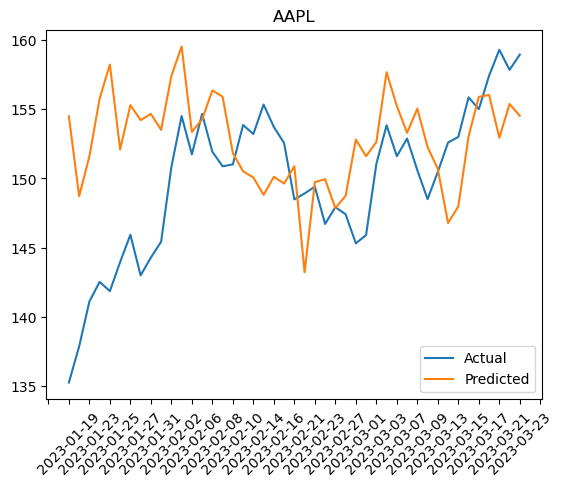

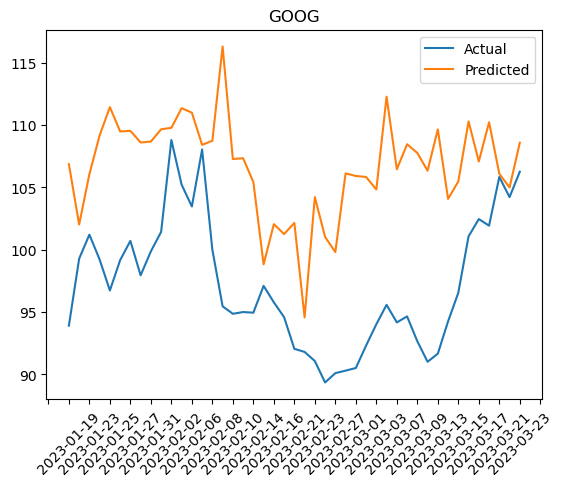

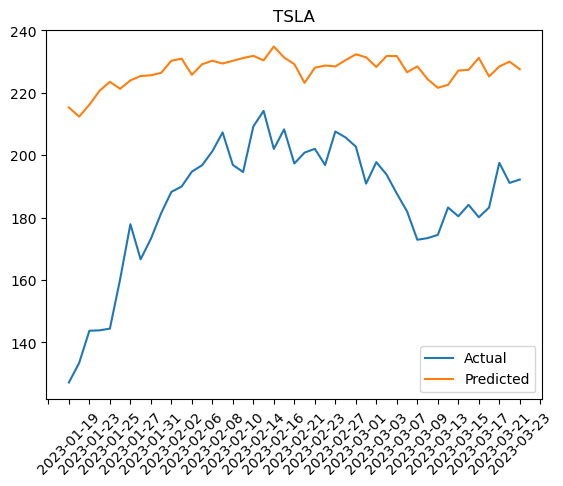

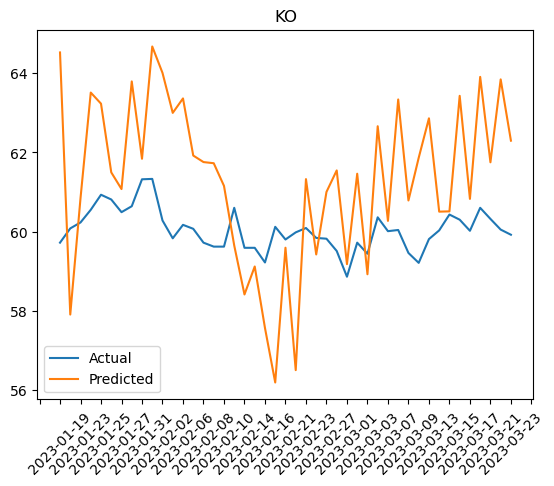

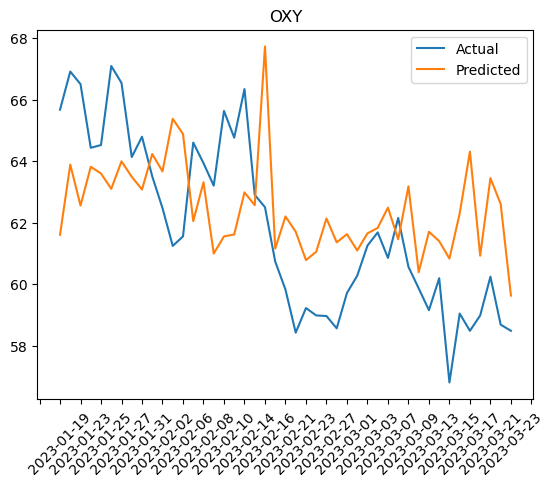

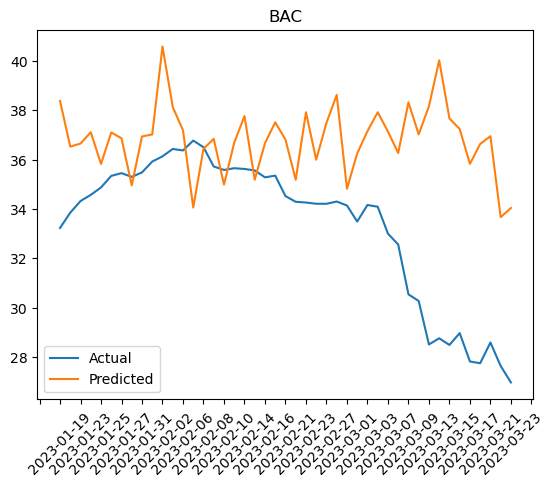

In [106]:
model3.eval()
actual = []
preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        pred = model3(x)
        actual.append(y.squeeze(-1))
        preds.append(pred)
preds = torch.cat(preds, dim=0)
actual = torch.cat(actual,dim=0)
    
dates = df_origin[200:250]['Date'].values
dates = dates[5:]
ticker = df_origin['Ticker'].unique()
preds_unscaled3 = test_scaler.inverse_transform(preds)
actual_unscaled3 = test_scaler.inverse_transform(actual)

for i in range(6):
    result = compare(actual_unscaled3[i*45:(i+1)*45], preds_unscaled3[i*45:(i+1)*45])
    print("Percent of same trends for ", ticker[i], ": ", result/45)
    print("MSELoss: ", np.mean((actual_unscaled3[i*45:(i+1)*45] - preds_unscaled3[i*45:(i+1)*45]) ** 2))

for i,t in enumerate(ticker):
    length = 45
    plt.figure()
    plotResults(dates=dates, y=actual_unscaled3[i*length:(i+1)*length].reshape(-1),y_pred=preds_unscaled3[i*length:(i+1)*length].reshape(-1),title=t)
    plt.show()

In [51]:
class Model4(nn.Module):
   def __init__(self, hidden_size):
      super().__init__()
      self.cnn = nn.Sequential(
         nn.Conv1d(11, 128, kernel_size=2),
         nn.ReLU(),
         nn.Dropout(0.2),
         nn.Conv1d(128, 64, kernel_size=2),
         nn.ReLU(),
         nn.Dropout(0.2)
      )
      self.lstm =  nn.LSTM(input_size=64,hidden_size=hidden_size,num_layers=1,batch_first=True, bidirectional=True)
      self.linear = nn.Linear(hidden_size*2,1)
      
   def forward(self, X):
      X = X.permute(0, 2, 1)
      out = self.cnn(X)
      out = out.permute(0, 2, 1)
      out, _ = self.lstm(out)
      out = out[:, -1, :]
      out = self.linear(out)
      return out  

model4 = Model4(128)
criterion = nn.MSELoss()
optimizer = optim.SGD(model4.parameters(), lr=0.1e-3, momentum=0.9)

model4.train()
for epoch in range(80):
    running_loss = 0.0
    for i, (x, y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model4(x)
        loss = criterion(outputs, y.squeeze(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'epoch: {epoch + 1} loss: {running_loss:.3f}')

epoch: 1 loss: 18.707
epoch: 2 loss: 13.390
epoch: 3 loss: 11.730
epoch: 4 loss: 11.120
epoch: 5 loss: 10.849
epoch: 6 loss: 10.711
epoch: 7 loss: 10.642
epoch: 8 loss: 10.576
epoch: 9 loss: 10.501
epoch: 10 loss: 10.446
epoch: 11 loss: 10.404
epoch: 12 loss: 10.360
epoch: 13 loss: 10.289
epoch: 14 loss: 10.255
epoch: 15 loss: 10.183
epoch: 16 loss: 10.126
epoch: 17 loss: 10.090
epoch: 18 loss: 9.998
epoch: 19 loss: 9.935
epoch: 20 loss: 9.834
epoch: 21 loss: 9.823
epoch: 22 loss: 9.682
epoch: 23 loss: 9.645
epoch: 24 loss: 9.574
epoch: 25 loss: 9.482
epoch: 26 loss: 9.389
epoch: 27 loss: 9.283
epoch: 28 loss: 9.186
epoch: 29 loss: 9.061
epoch: 30 loss: 8.962
epoch: 31 loss: 8.805
epoch: 32 loss: 8.719
epoch: 33 loss: 8.652
epoch: 34 loss: 8.464
epoch: 35 loss: 8.383
epoch: 36 loss: 8.189
epoch: 37 loss: 8.012
epoch: 38 loss: 7.905
epoch: 39 loss: 7.663
epoch: 40 loss: 7.539
epoch: 41 loss: 7.327
epoch: 42 loss: 7.173
epoch: 43 loss: 6.972
epoch: 44 loss: 6.765
epoch: 45 loss: 6.661
ep

Percent of same trends for  AAPL :  0.6666666666666666
MSELoss:  66.12074718190088
Percent of same trends for  GOOG :  0.6
MSELoss:  116.45998567924184
Percent of same trends for  TSLA :  0.6444444444444445
MSELoss:  1487.4429700328053
Percent of same trends for  KO :  0.5333333333333333
MSELoss:  38.94167482315346
Percent of same trends for  OXY :  0.4222222222222222
MSELoss:  15.529935531067856
Percent of same trends for  BAC :  0.5555555555555556
MSELoss:  56.291122305346306


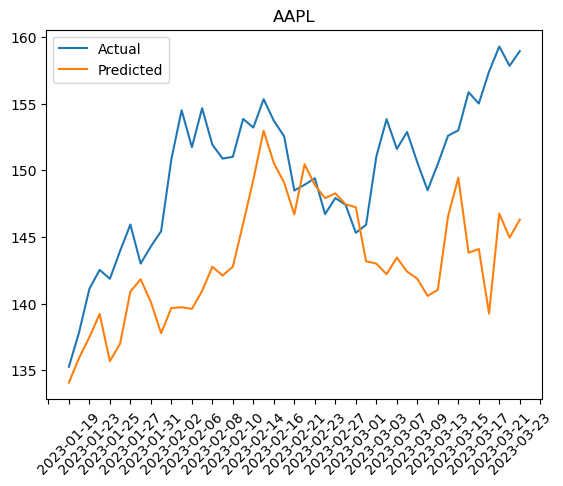

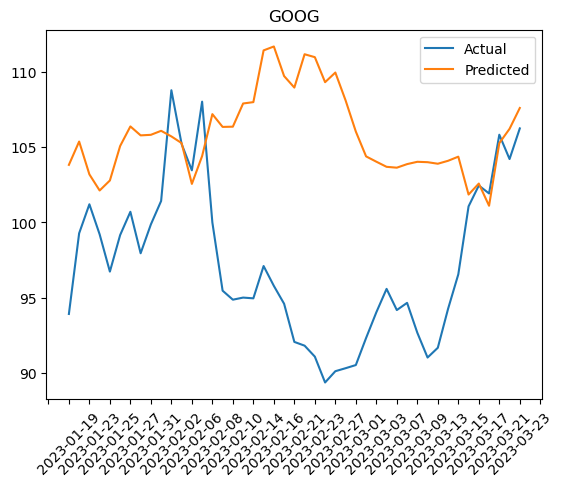

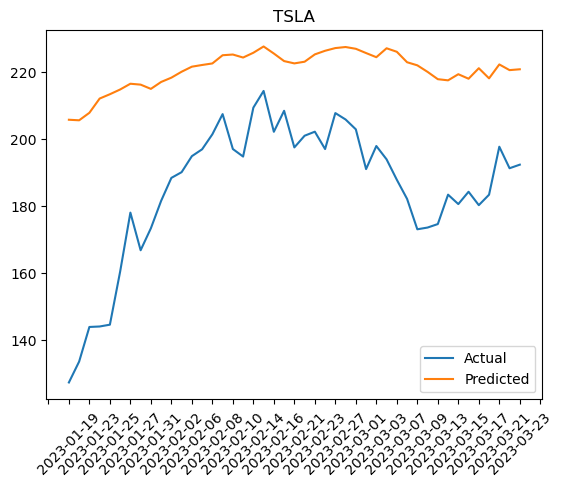

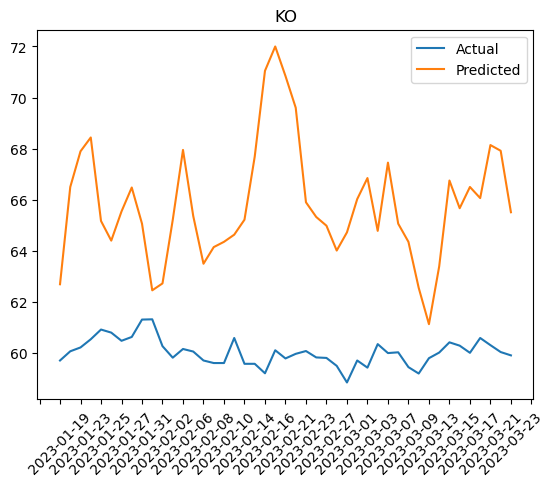

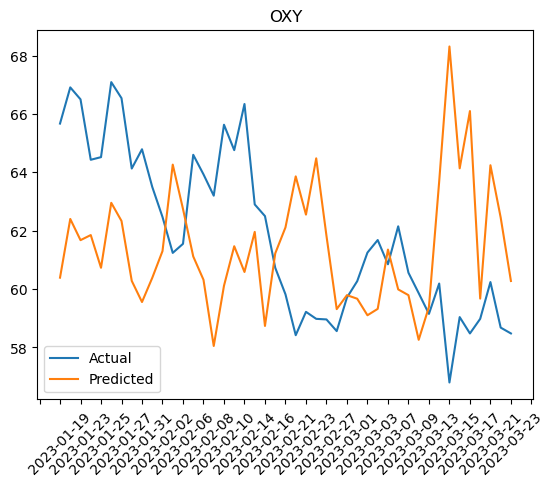

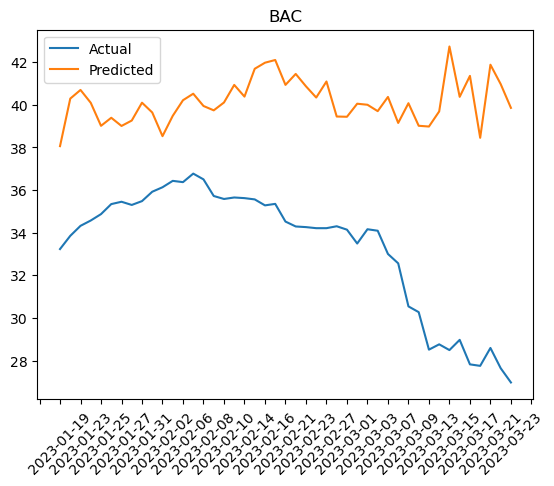

In [107]:
model4.eval()
actual = []
preds = []
with torch.no_grad():
    for i, (x, y) in enumerate(test_dataloader):
        pred = model4(x)
        actual.append(y.squeeze(-1))
        preds.append(pred)
preds = torch.cat(preds, dim=0)
actual = torch.cat(actual,dim=0)
    
dates = df_origin[200:250]['Date'].values
dates = dates[5:]
ticker = df_origin['Ticker'].unique()
preds_unscaled4 = test_scaler.inverse_transform(preds)
actual_unscaled4 = test_scaler.inverse_transform(actual)

for i in range(6):
    result = compare(actual_unscaled4[i*45:(i+1)*45], preds_unscaled4[i*45:(i+1)*45])
    print("Percent of same trends for ", ticker[i], ": ", result/45)
    print("MSELoss: ", np.mean((actual_unscaled4[i*45:(i+1)*45] - preds_unscaled4[i*45:(i+1)*45]) ** 2))

for i,t in enumerate(ticker):
    length = 45
    plt.figure()
    plotResults(dates=dates, y=actual_unscaled4[i*length:(i+1)*length].reshape(-1),y_pred=preds_unscaled4[i*length:(i+1)*length].reshape(-1),title=t)
    plt.show()

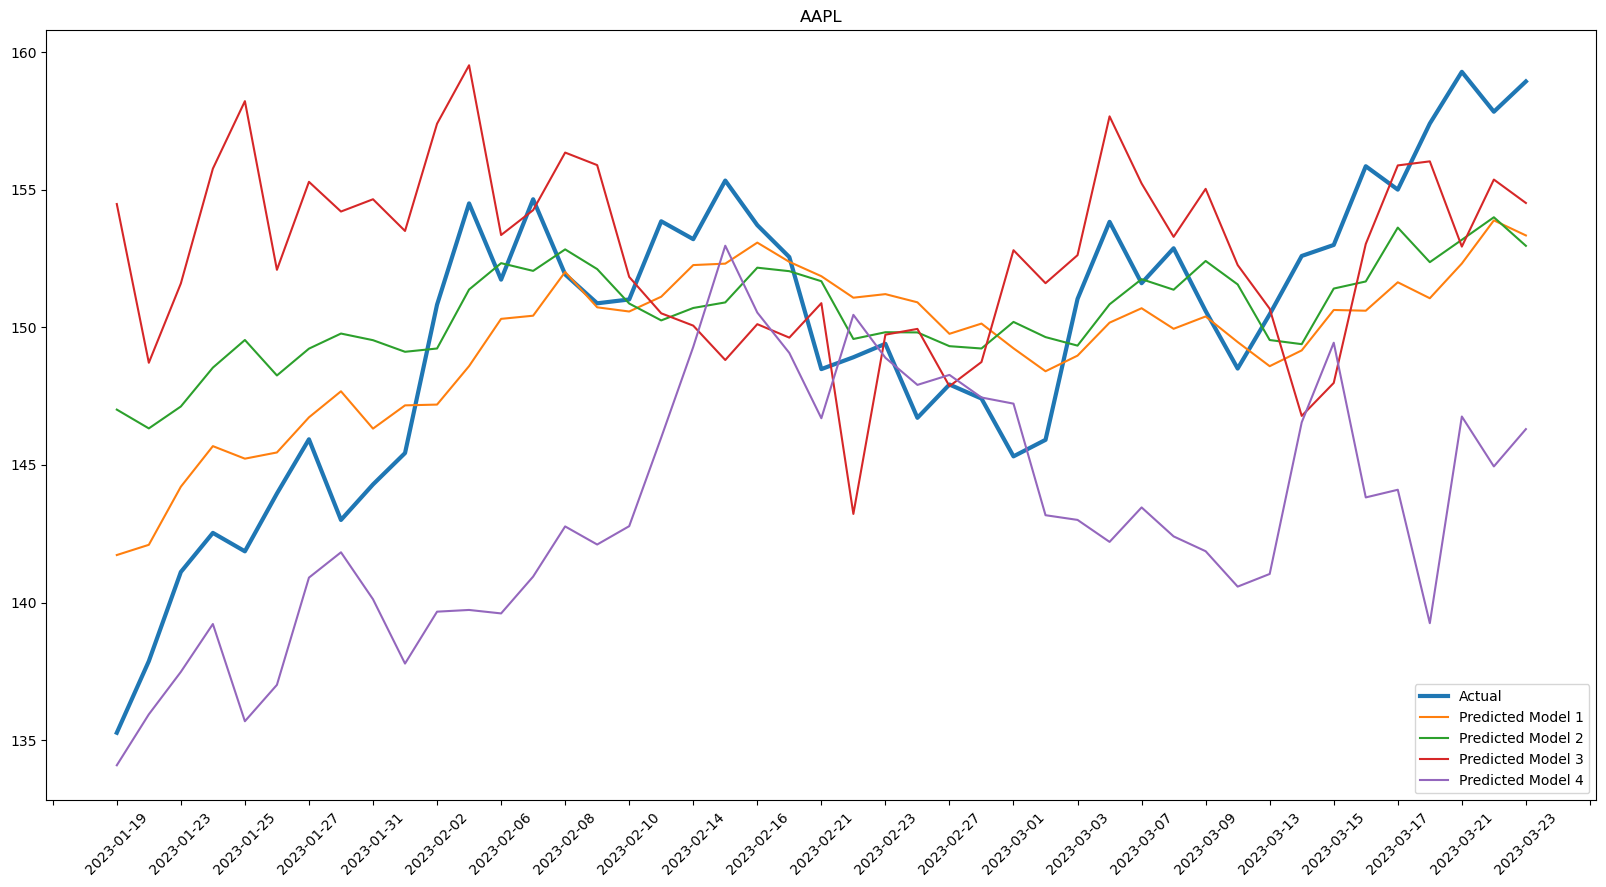

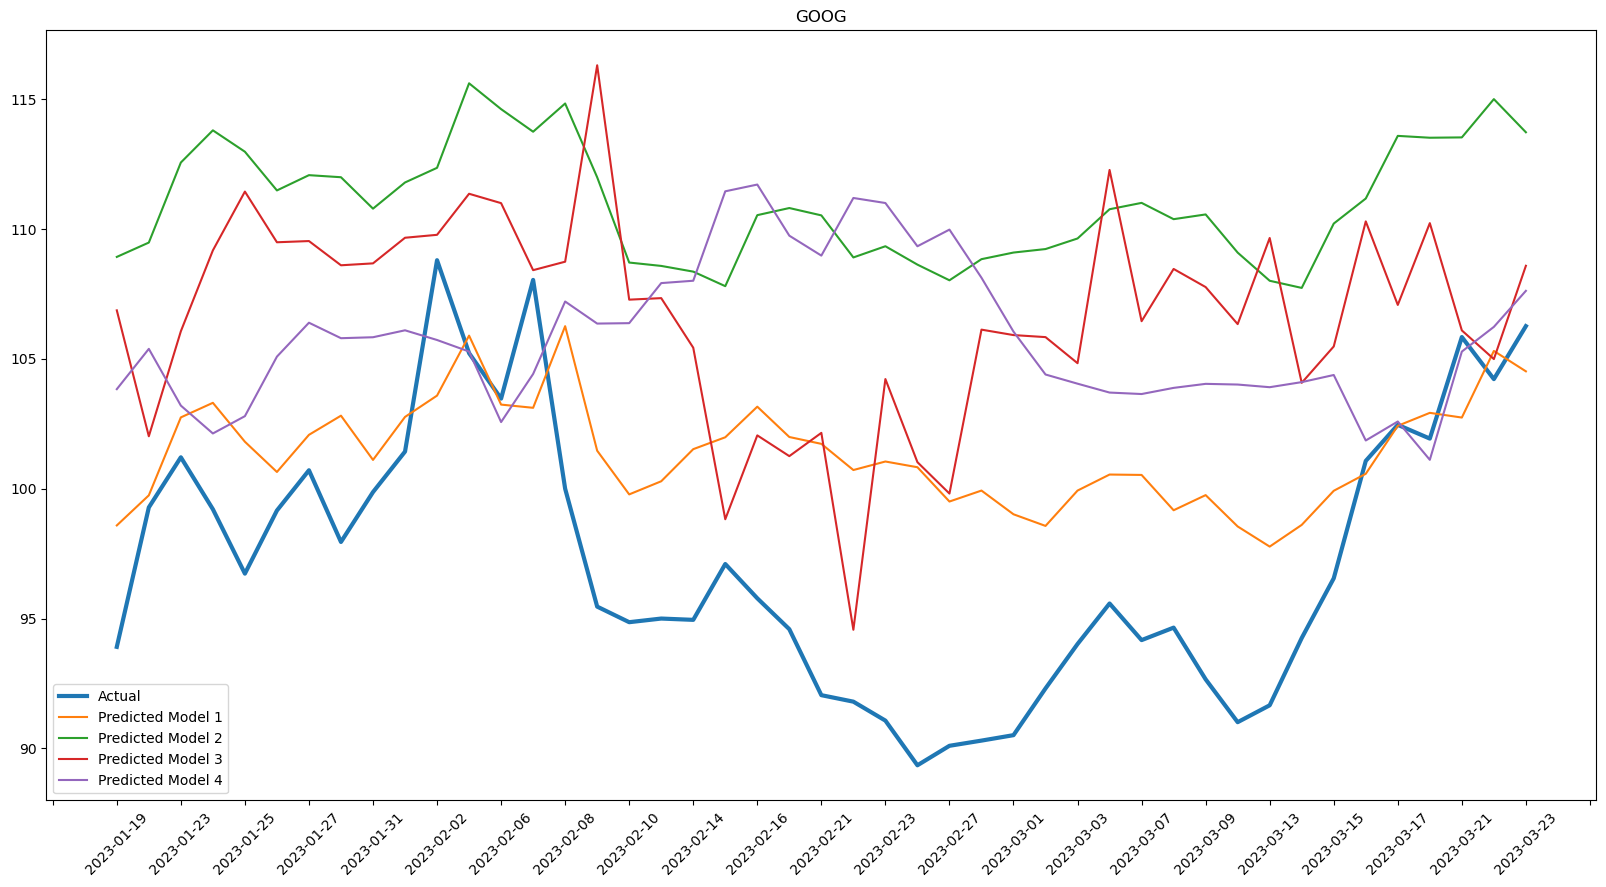

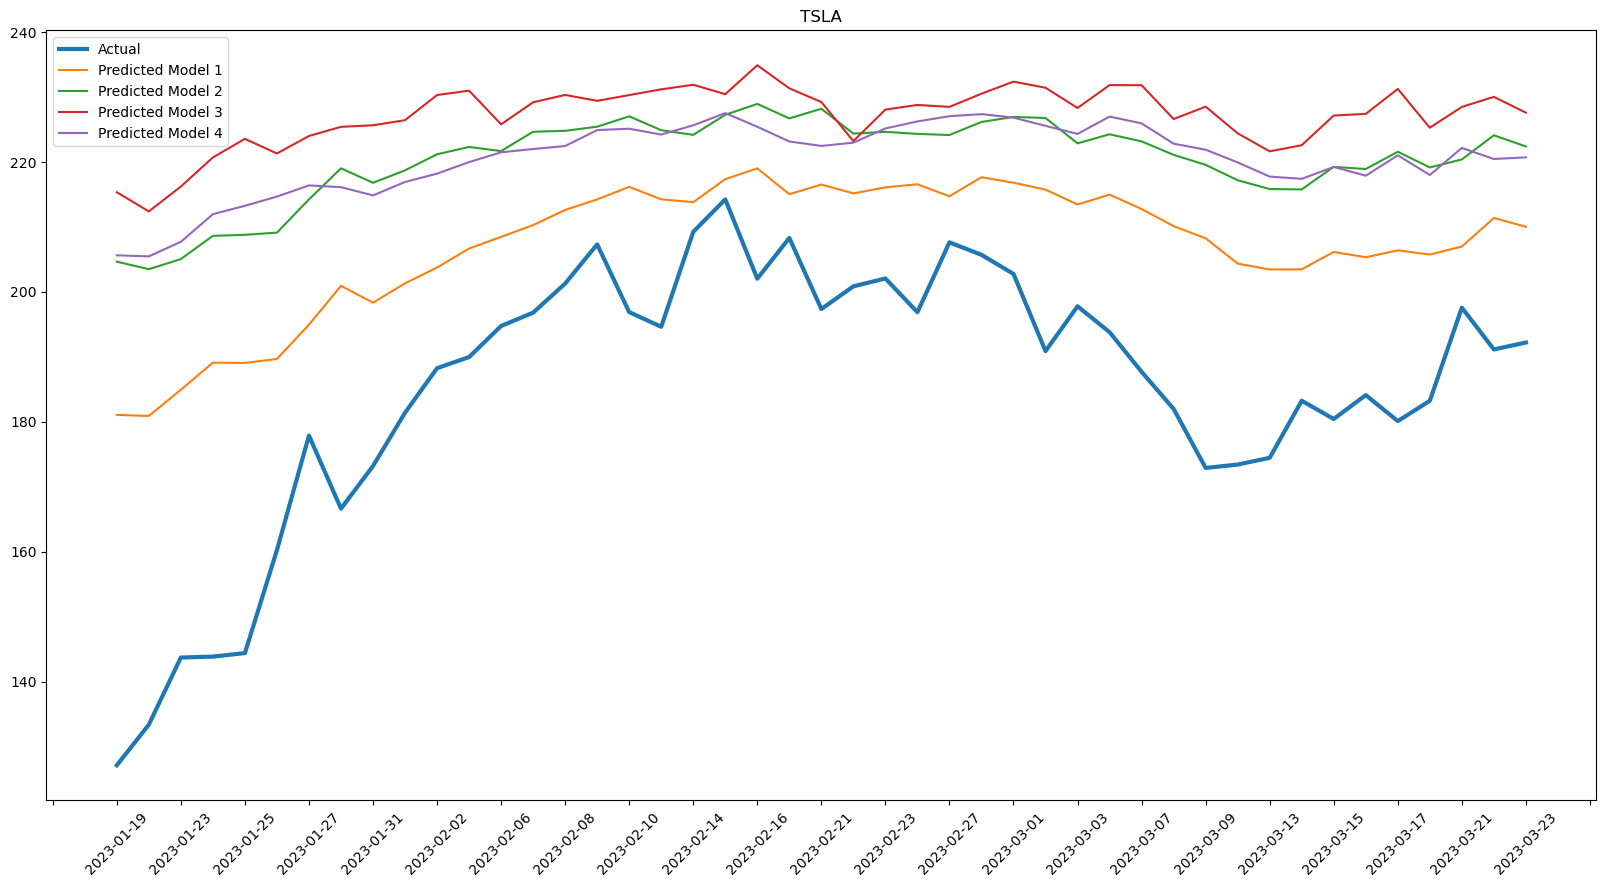

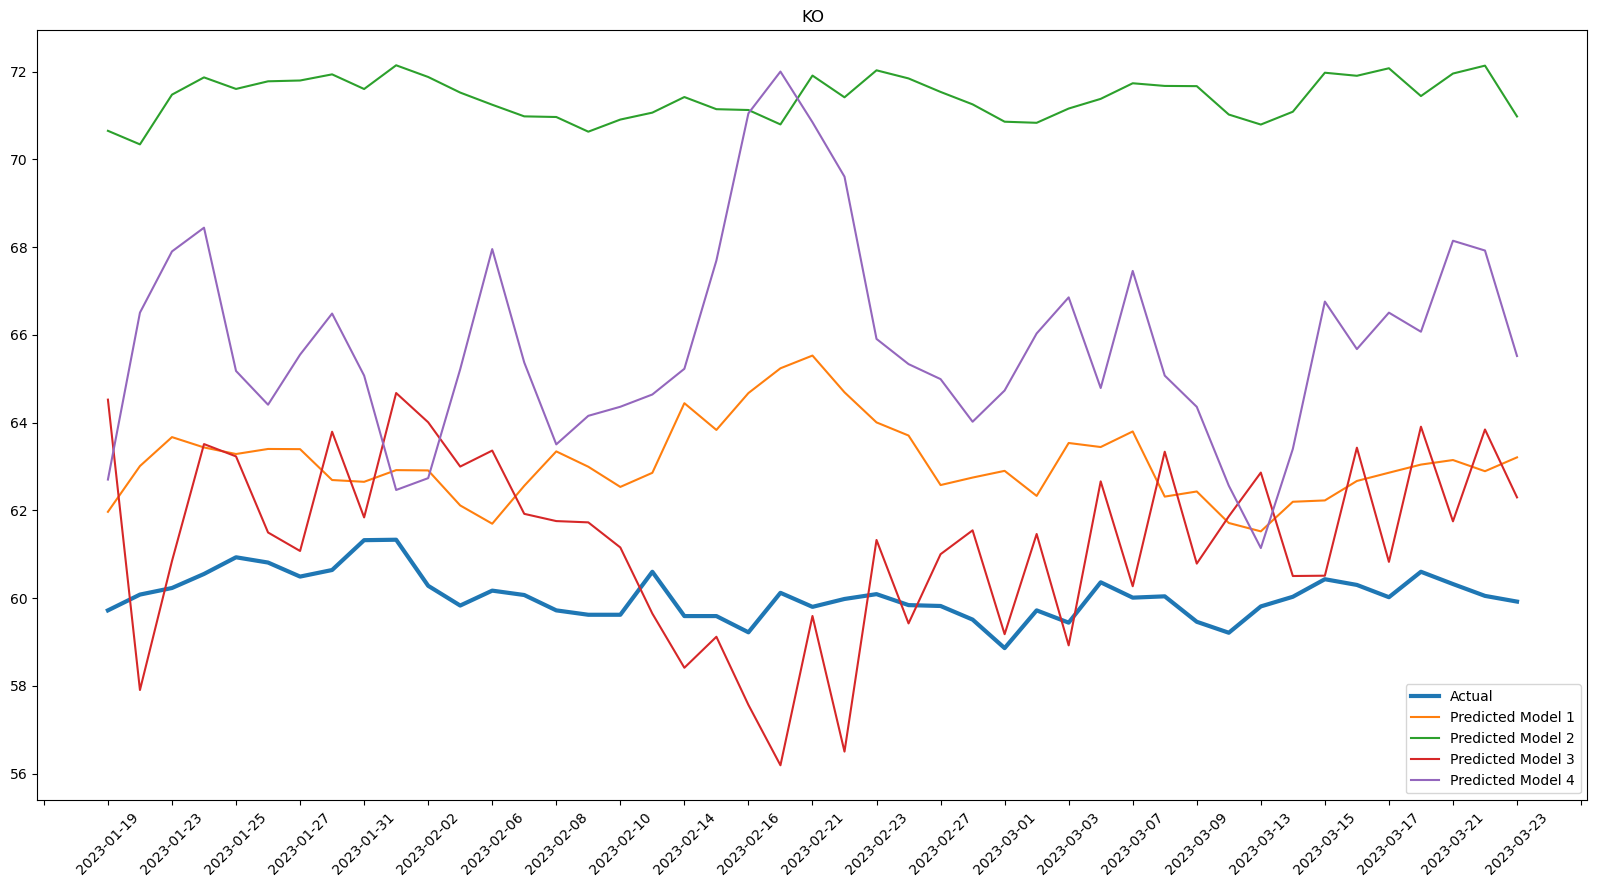

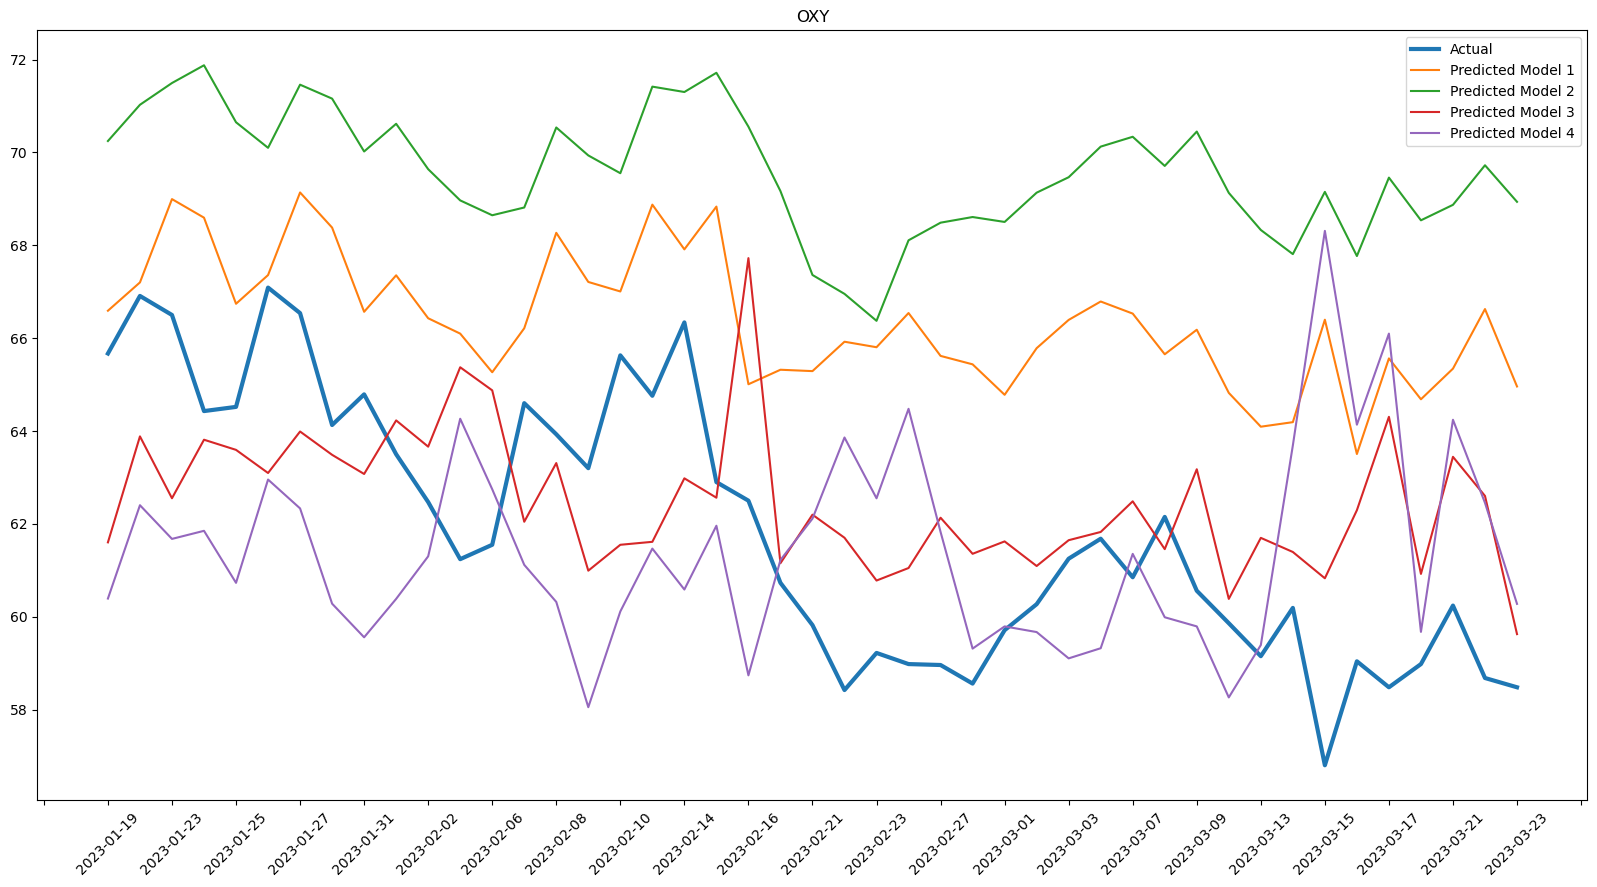

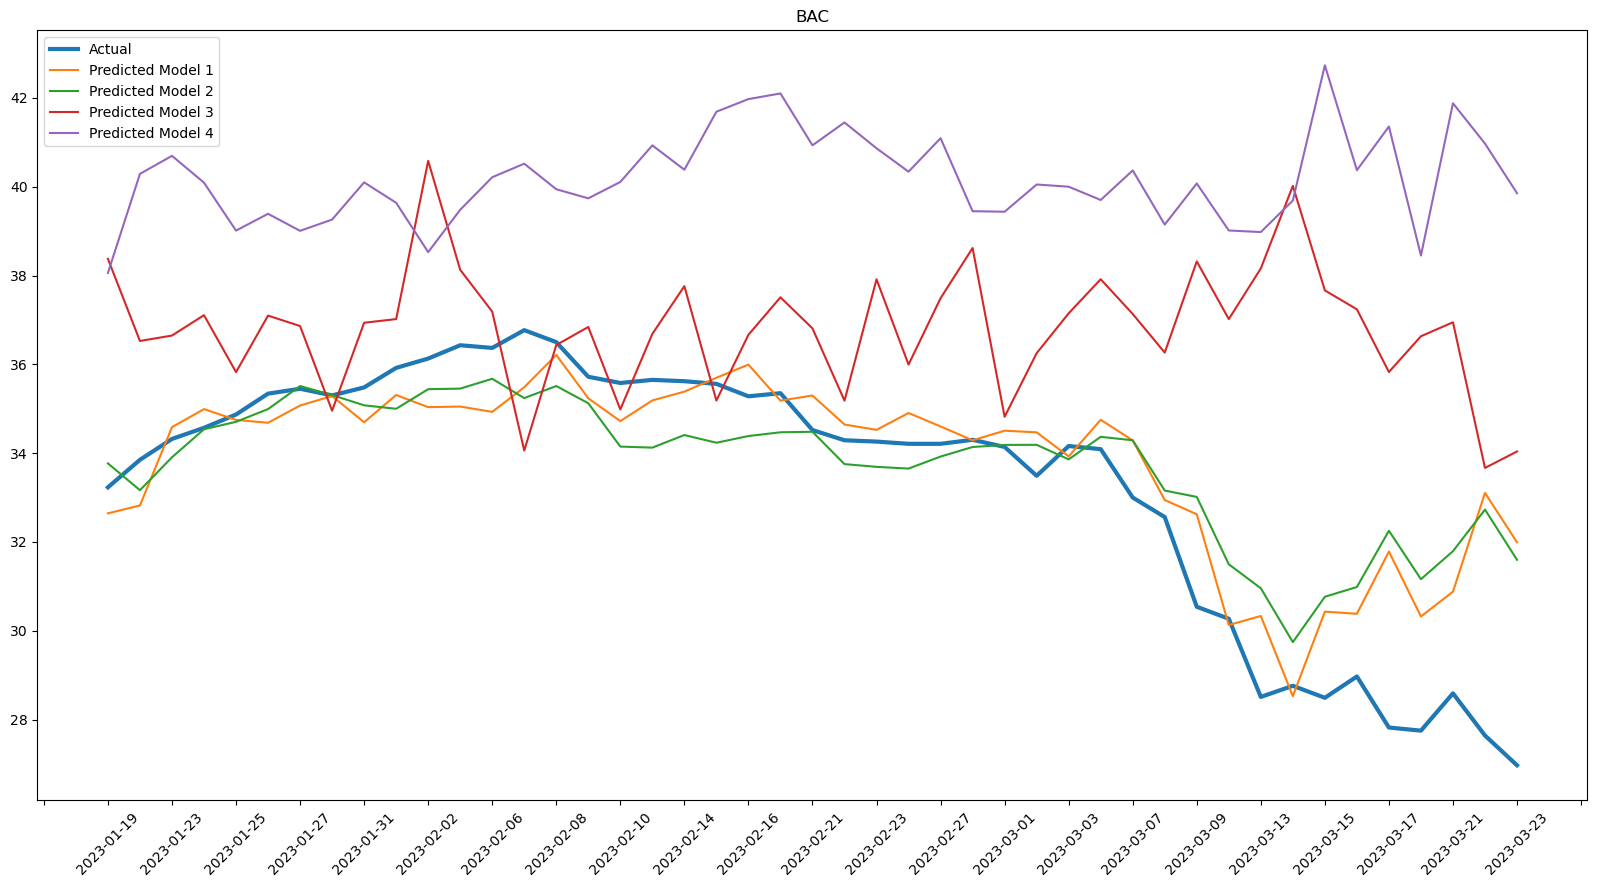

In [114]:
for i,t in enumerate(ticker):
    length = 45
    plt.figure(figsize=(20,10))
    ax = sns.lineplot(x=dates, y=actual_unscaled4[i*length:(i+1)*length].reshape(-1),label='Actual', linewidth = 3)
    sns.lineplot(x=dates, y=preds_unscaled1[i*length:(i+1)*length].reshape(-1), label='Predicted Model 1')
    sns.lineplot(x=dates, y=preds_unscaled2[i*length:(i+1)*length].reshape(-1), label='Predicted Model 2')
    sns.lineplot(x=dates, y=preds_unscaled3[i*length:(i+1)*length].reshape(-1), label='Predicted Model 3')
    sns.lineplot(x=dates, y=preds_unscaled4[i*length:(i+1)*length].reshape(-1), label='Predicted Model 4')
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.tick_params(axis='x', rotation=45)
    plt.title(t)
    plt.show()


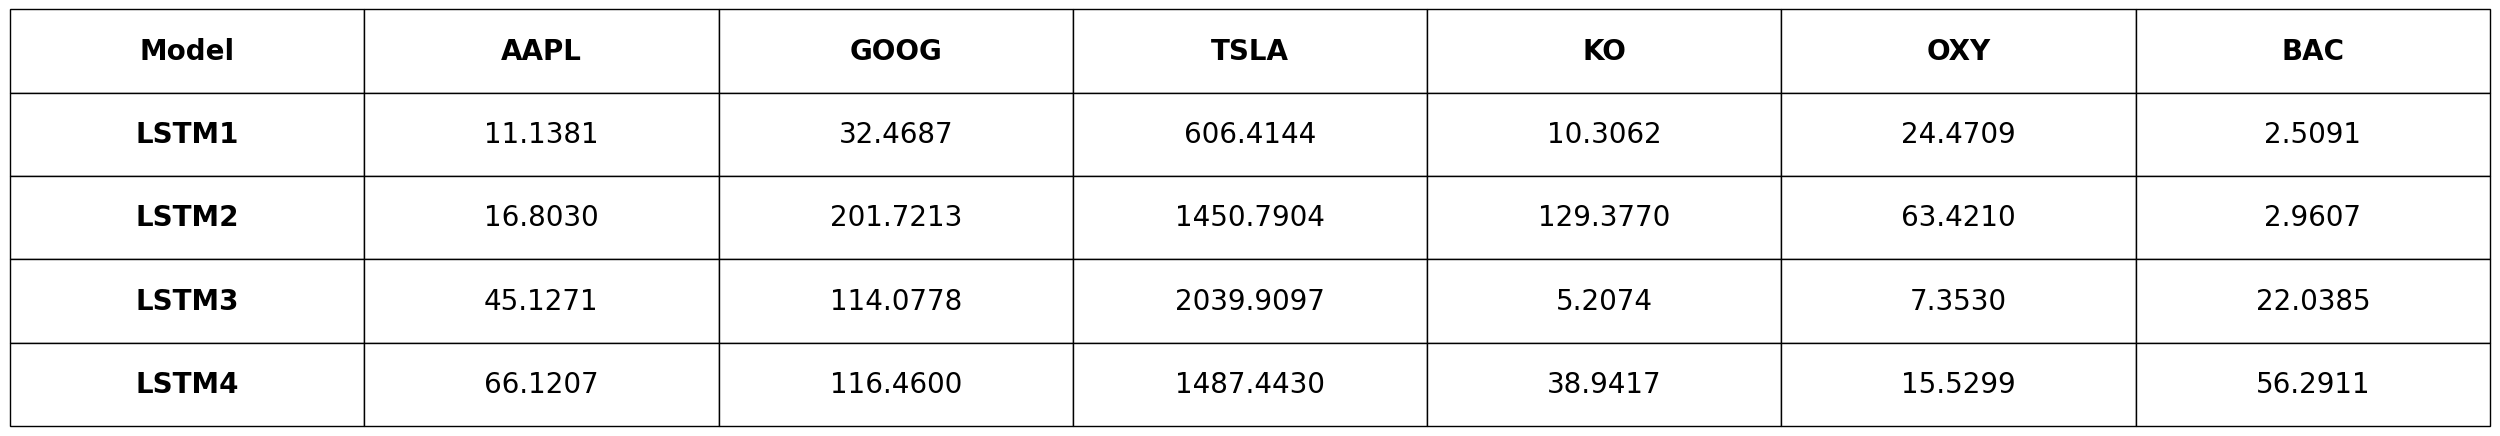

In [32]:
column_names = ['Model', 'AAPL', 'GOOG', 'TSLA', 'KO', 'OXY', 'BAC']
data = [
    ['LSTM1', 11.138087385395481, 32.468676242267854, 606.4143636668954, 10.306227991429319, 24.47091926564454,2.509058371824187],
    ['LSTM2', 16.80295273764209, 201.72132949466803, 1450.7904404848646, 129.37704649547018, 63.42096272959061, 2.9606894807663107],
    ['LSTM3', 45.12714156869217, 114.07781376966335, 2039.9097397418548, 5.2073783587434015, 7.353028617818142, 22.038542483492957],
    ['LSTM4', 66.12074718190088, 116.45998567924184, 1487.442970032805, 38.94167482315346, 15.529935531067856, 56.291122305346306]
]

data = [['{:.4f}'.format(x) if isinstance(x, float) else x for x in row] for row in data]

fig, ax = plt.subplots()

# Hide the axes and ticks
ax.axis('off')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Create the table and add it to the axis
table = ax.table(cellText=data, colLabels=column_names, cellLoc='center', loc='center')

# Adjust the table properties if needed
table.auto_set_font_size(True)
table.set_fontsize(20)
table.scale(5, 5)

for (row, col), cell in table.get_celld().items():
    if row == 0 or col == 0:
        cell.set_text_props(fontweight='bold')

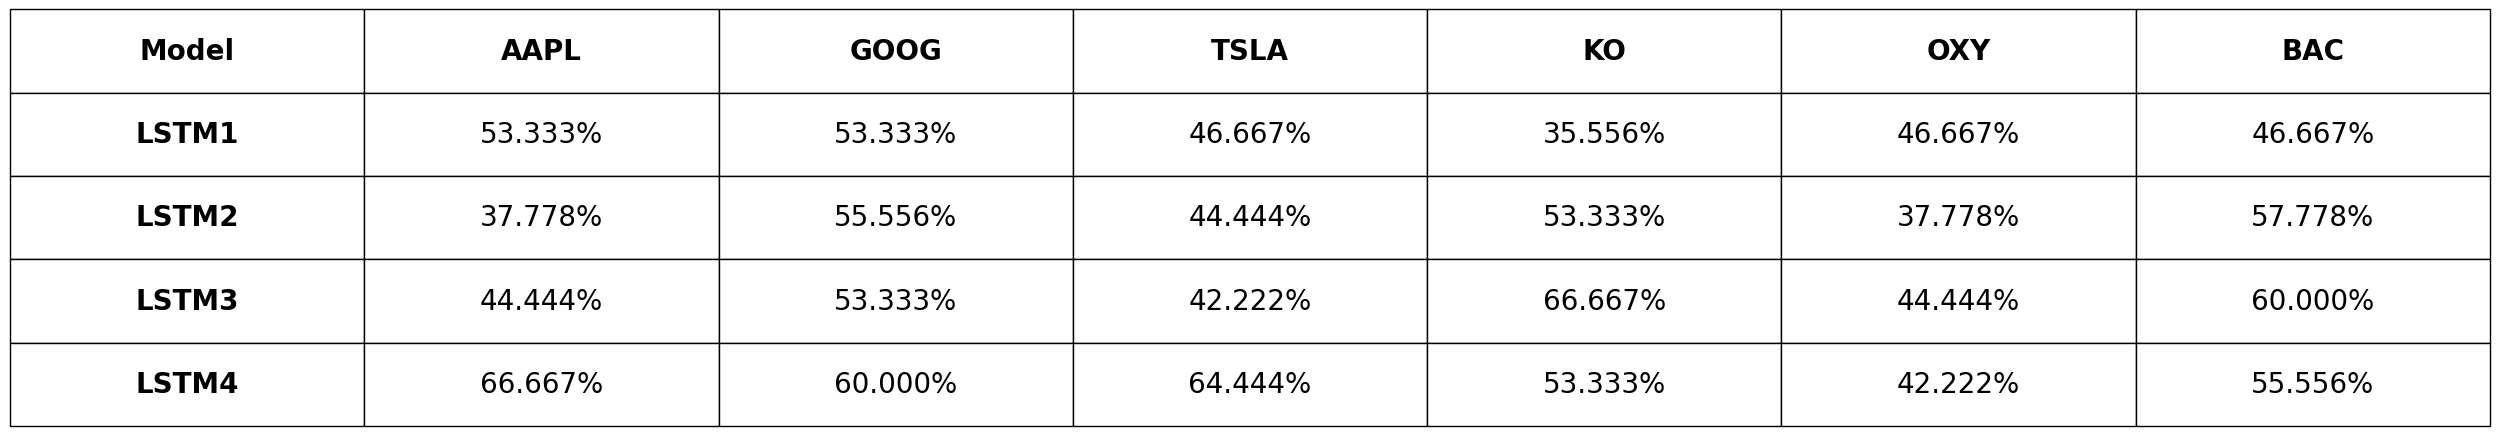

In [34]:
column_names = ['Model', 'AAPL', 'GOOG', 'TSLA', 'KO', 'OXY', 'BAC']
data = [
    ['LSTM1', 0.5333333333333333, 0.5333333333333333, 0.4666666666666667, 0.35555555555555557, 0.4666666666666667, 0.4666666666666667],
    ['LSTM2', 0.37777777777777777, 0.5555555555555556, 0.4444444444444444, 0.5333333333333333, 0.37777777777777777, 0.5777777777777777],
    ['LSTM3', 0.4444444444444444, 0.5333333333333333, 0.4222222222222222, 0.6666666666666666, 0.4444444444444444,  0.6],
    ['LSTM4', 0.6666666666666666, 0.6, 0.6444444444444445, 0.5333333333333333, 0.4222222222222222, 0.5555555555555556]
]

data = [['{:.3f}%'.format(x*100) if isinstance(x, float) else x for x in row] for row in data]

fig, ax = plt.subplots()

# Hide the axes and ticks
ax.axis('off')
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Create the table and add it to the axis
table = ax.table(cellText=data, colLabels=column_names, cellLoc='center', loc='center')

# Adjust the table properties if needed
table.auto_set_font_size(True)
table.set_fontsize(20)
table.scale(5, 5)

for (row, col), cell in table.get_celld().items():
    if row == 0 or col == 0:
        cell.set_text_props(fontweight='bold')